In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 0. Add checkout entries or late customers
Not all customers have a checkout entry because the supermarket closed to early.     
You can add these entries by hand

In [100]:
monday = pd.read_csv('data/monday.csv', sep=';')
tuesday = pd.read_csv('data/tuesday.csv', sep=';')
wednesday = pd.read_csv('data/wednesday.csv', sep=';')
thursday = pd.read_csv('data/thursday.csv', sep=';')
friday = pd.read_csv('data/friday.csv', sep=';')

days_data = [monday, tuesday, wednesday, thursday, friday]


In [101]:
monday['day'] = 'monday'
tuesday['day'] = 'tuesday'
wednesday['day'] = 'wednesday'
thursday['day'] = 'thursday'
friday['day'] = 'friday'

In [102]:
for day in days_data:
    day.timestamp = pd.to_datetime(day.timestamp)
    day.set_index('timestamp', inplace=True)

In [103]:
def get_non_checkout(df):
    non_checkout_customers = df['customer_no'].max()
    checkout_customers = []
    for c_id in range(non_checkout_customers):
        if not 'checkout' in df[df['customer_no'] == c_id+1]['location'].values:
            checkout_customers.append(c_id+1)
    return checkout_customers

In [104]:
customers_to_checkout = []
for day in days_data:
    customers_to_checkout.append(get_non_checkout(day))

In [105]:
customers_to_checkout

[[1430, 1433, 1437, 1439, 1440, 1441, 1443, 1445, 1446, 1447],
 [1411, 1422],
 [1520, 1527, 1528, 1529, 1530],
 [1527, 1532, 1533],
 [1494, 1496, 1500, 1503, 1505, 1506, 1509, 1510]]

In [106]:
def add_checkout(df, customer_nos, date, day):
    df_fill = pd.DataFrame()
    for p_id in customer_nos:
        df_tmp = pd.DataFrame(data=[[p_id, 'checkout', day]], index=[pd.to_datetime(f'2019-09-{date} 21:59:00')], columns=['customer_no', 'location', 'day'])
        df = pd.concat([df, df_tmp])
    return df

In [107]:
filled_data = []
weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
date = ['02', '03', '04', '05', '06']
for i, day in enumerate(days_data):
    filled_data.append(add_checkout(day, customers_to_checkout[i], date[i], weekdays[i]))

Combine data to one dataset

In [108]:
total = pd.concat(filled_data)

In [109]:
total

,customer_no,location,day
2019-09-02 07:03:00,1,dairy,monday
2019-09-02 07:03:00,2,dairy,monday
2019-09-02 07:04:00,3,dairy,monday
2019-09-02 07:04:00,4,dairy,monday
2019-09-02 07:04:00,5,spices,monday
...,...,...,...
2019-09-06 21:59:00,1503,checkout,friday
2019-09-06 21:59:00,1505,checkout,friday
2019-09-06 21:59:00,1506,checkout,friday
2019-09-06 21:59:00,1509,checkout,friday


### 1. Set time step to 1 min
To allow customers to stay in a department we need to change the resolution to 1 min

In [110]:
perminute = total.groupby(['customer_no', 'day']).resample('1Min').ffill()

In [111]:
perminute

customer_no  location       day
customer_no day                                                          
1           friday   2019-09-06 07:00:00            1     dairy    friday
                     2019-09-06 07:01:00            1     dairy    friday
                     2019-09-06 07:02:00            1     dairy    friday
                     2019-09-06 07:03:00            1     dairy    friday
                     2019-09-06 07:04:00            1    spices    friday
...                                               ...       ...       ...
1533        thursday 2019-09-05 21:59:00         1533  checkout  thursday
1534        thursday 2019-09-05 21:48:00         1534     fruit  thursday
                     2019-09-05 21:49:00         1534  checkout  thursday
1535        thursday 2019-09-05 21:48:00         1535    spices  thursday
                     2019-09-05 21:49:00         1535  checkout  thursday

[54192 rows x 3 columns]

Shift the `location` column to get a `from` column that describes the moving

In [112]:
perminute['from'] = perminute['location'].shift(1)

In [113]:
perminute

customer_no  location       day  \
customer_no day                                                             
1           friday   2019-09-06 07:00:00            1     dairy    friday   
                     2019-09-06 07:01:00            1     dairy    friday   
                     2019-09-06 07:02:00            1     dairy    friday   
                     2019-09-06 07:03:00            1     dairy    friday   
                     2019-09-06 07:04:00            1    spices    friday   
...                                               ...       ...       ...   
1533        thursday 2019-09-05 21:59:00         1533  checkout  thursday   
1534        thursday 2019-09-05 21:48:00         1534     fruit  thursday   
                     2019-09-05 21:49:00         1534  checkout  thursday   
1535        thursday 2019-09-05 21:48:00         1535    spices  thursday   
                     2019-09-05 21:49:00         1535  checkout  thursday   

                                              from  
customer_no day                                     
1           friday   2019-09-06 07:00:00      None  
                     2019-09-06 07:01:00     dairy  
                     2019-09-06 07:02:00     dairy  
                     2019-09-06 07:03:00     dairy  
                     2019-09-06 07:04:00     dairy  
...                                            ...  
1533        thursday 2019-09-05 21:59:00     dairy  
1534        thursday 2019-09-05 21:48:00  checkout  
                     2019-09-05 21:49:00     fruit  
1535        thursday 2019-09-05 21:48:00  checkout  
                     2019-09-05 21:49:00    spices  

[54192 rows x 4 columns]

Fill the evolving `nan`

In [114]:
perminute.fillna('checkout', inplace=True)

Use `crosstab` to get the TM

In [115]:
tm = pd.crosstab(perminute['from'], perminute['location'], normalize='index')
tm

location,checkout,dairy,drinks,fruit,spices
from,,,,,
checkout,0.000000,0.287576,0.153526,0.377435,0.181464
dairy,0.102697,0.738706,0.058134,0.049478,0.050986
drinks,0.215334,0.010880,0.599199,0.087755,0.086832
fruit,0.200564,0.095428,0.054564,0.599029,0.050415
spices,0.149613,0.191839,0.161948,0.090305,0.406294


In [116]:
tm.rename({'checkout': 'entry'}, inplace=True)
tm

location,checkout,dairy,drinks,fruit,spices
from,,,,,
entry,0.000000,0.287576,0.153526,0.377435,0.181464
dairy,0.102697,0.738706,0.058134,0.049478,0.050986
drinks,0.215334,0.010880,0.599199,0.087755,0.086832
fruit,0.200564,0.095428,0.054564,0.599029,0.050415
spices,0.149613,0.191839,0.161948,0.090305,0.406294


In [119]:
dfs= perminute
dfs.rename(columns={'day': 'new_day'}, inplace=True)
dfs.rename(columns={'customer_no': 'customer_no_no'}, inplace=True)
dfs = dfs.drop('new_day', axis=1)
dfs = dfs.drop('customer_no_no', axis=1)
dfs

location      from
customer_no day                                             
1           friday   2019-09-06 07:00:00     dairy  checkout
                     2019-09-06 07:01:00     dairy     dairy
                     2019-09-06 07:02:00     dairy     dairy
                     2019-09-06 07:03:00     dairy     dairy
                     2019-09-06 07:04:00    spices     dairy
...                                            ...       ...
1533        thursday 2019-09-05 21:59:00  checkout     dairy
1534        thursday 2019-09-05 21:48:00     fruit  checkout
                     2019-09-05 21:49:00  checkout     fruit
1535        thursday 2019-09-05 21:48:00    spices  checkout
                     2019-09-05 21:49:00  checkout    spices

[54192 rows x 2 columns]

In [120]:
dfs = dfs.reset_index()
dfs.rename(columns={'day': 'day_of_week'}, inplace=True)
dfs.rename(columns={'level_2': 'timestep'}, inplace=True)
dfs

,customer_no,day_of_week,timestep,location,from
0,1,friday,2019-09-06 07:00:00,dairy,checkout
1,1,friday,2019-09-06 07:01:00,dairy,dairy
2,1,friday,2019-09-06 07:02:00,dairy,dairy
3,1,friday,2019-09-06 07:03:00,dairy,dairy
4,1,friday,2019-09-06 07:04:00,spices,dairy
...,...,...,...,...,...
54187,1533,thursday,2019-09-05 21:59:00,checkout,dairy
54188,1534,thursday,2019-09-05 21:48:00,fruit,checkout
54189,1534,thursday,2019-09-05 21:49:00,checkout,fruit
54190,1535,thursday,2019-09-05 21:48:00,spices,checkout


In [121]:
dfs['timestep'] = pd.to_datetime(dfs['timestep'])
dfs['year'] = dfs['timestep'].dt.year
dfs['month'] = dfs['timestep'].dt.month
dfs['day'] = dfs['timestep'].dt.day
dfs['hour'] = dfs['timestep'].dt.hour
dfs['minute'] = dfs['timestep'].dt.minute
dfs['day_per_minute'] = dfs['hour']*60 +dfs['minute'] 
dfs

,customer_no,day_of_week,timestep,location,from,year,month,day,hour,minute,day_per_minute
0,1,friday,2019-09-06 07:00:00,dairy,checkout,2019,9,6,7,0,420
1,1,friday,2019-09-06 07:01:00,dairy,dairy,2019,9,6,7,1,421
2,1,friday,2019-09-06 07:02:00,dairy,dairy,2019,9,6,7,2,422
3,1,friday,2019-09-06 07:03:00,dairy,dairy,2019,9,6,7,3,423
4,1,friday,2019-09-06 07:04:00,spices,dairy,2019,9,6,7,4,424
...,...,...,...,...,...,...,...,...,...,...,...
54187,1533,thursday,2019-09-05 21:59:00,checkout,dairy,2019,9,5,21,59,1319
54188,1534,thursday,2019-09-05 21:48:00,fruit,checkout,2019,9,5,21,48,1308
54189,1534,thursday,2019-09-05 21:49:00,checkout,fruit,2019,9,5,21,49,1309
54190,1535,thursday,2019-09-05 21:48:00,spices,checkout,2019,9,5,21,48,1308


<Axes: xlabel='hour', ylabel='customer_no_count'>

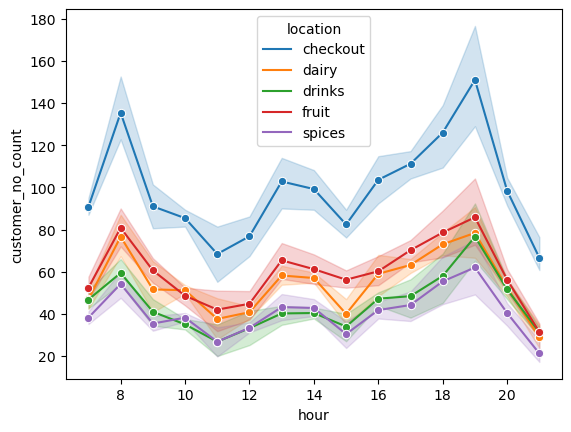

In [122]:
grouped = dfs.groupby(['location','day_of_week', 'hour'])['customer_no'].unique().reset_index()
grouped
grouped['customer_no_count'] = grouped['customer_no'].apply(len)

#sns.barplot(data=grouped, x='day', y='customer_no_count', hue='location')
#sns.barplot(data=grouped, x='day', y='customer_no_count', hue='location')
sns.lineplot(data=grouped, x='hour', y='customer_no_count', hue='location', marker='o')


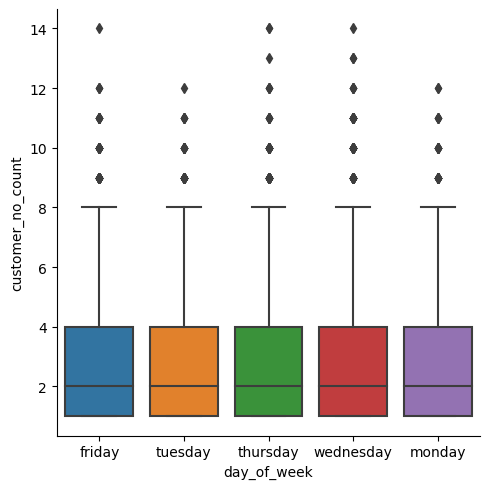

In [137]:
grouped = dfs.groupby(['location','day_of_week','day_per_minute' ])['customer_no'].unique().reset_index()
grouped
grouped['customer_no_count'] = grouped['customer_no'].apply(len)

#sns.barplot(data=grouped, x='day', y='customer_no_count', hue='location')
#sns.barplot(data=grouped, x='day', y='customer_no_count', hue='location')
#sns.catplot(data=grouped, x="day_per_minute", y="day_of_week", hue='customer_no_count', )

sns.catplot(
    data=grouped.sort_values("location"),
    x="day_of_week", y="customer_no_count", kind="box")

/var/folders/0p/clc57n8j74z930884d20xxb00000gn/T/ipykernel_60183/1688083353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_checkouts['customer_no_count'] = grouped_checkouts['customer_no'].apply(len)


<Axes: xlabel='day_per_minute', ylabel='customer_no_count'>

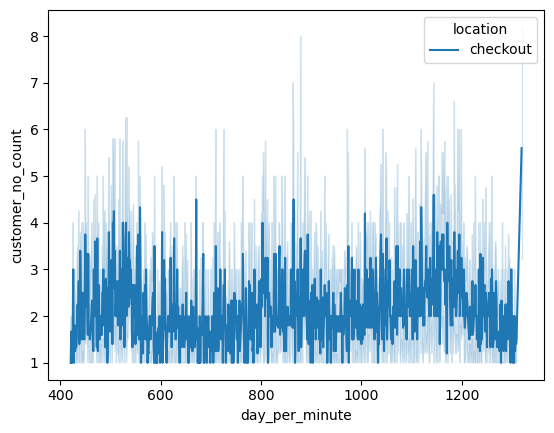

In [147]:
grouped = dfs.groupby(['location','day_of_week', 'day_per_minute'])['customer_no'].unique().reset_index()
grouped_checkouts = grouped[grouped['location'] == 'checkout']

grouped_checkouts['customer_no_count'] = grouped_checkouts['customer_no'].apply(len)
grouped_checkouts

sns.lineplot(data=grouped_checkouts, x='day_per_minute', y='customer_no_count', hue='location')


In [97]:
grouped = dfs.groupby(['day', 'location'])['customer_no'].unique().reset_index()
grouped
#grouped['customer_no_count'] = grouped['customer_no'].apply(len)
#plt.figure(figsize=(200, 50))

#sns.catplot(data=grouped, x="day", y="customer_no_count", hue='location')


,day,location,customer_no
0,2,checkout,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2,dairy,"[1, 2, 3, 4, 6, 9, 13, 16, 18, 22, 25, 26, 27,..."
2,2,drinks,"[6, 7, 11, 12, 19, 20, 21, 24, 25, 28, 29, 30,..."
3,2,fruit,"[7, 8, 9, 10, 13, 14, 15, 17, 18, 22, 23, 26, ..."
4,2,spices,"[5, 6, 7, 12, 13, 15, 16, 19, 21, 25, 27, 30, ..."
5,3,checkout,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
6,3,dairy,"[3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, ..."
7,3,drinks,"[1, 2, 4, 7, 13, 14, 16, 19, 21, 22, 24, 26, 2..."
8,3,fruit,"[1, 2, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 1..."
9,3,spices,"[4, 6, 15, 20, 21, 24, 26, 27, 28, 29, 31, 33,..."


In [151]:
tm.round(decimals=2)

location,checkout,dairy,drinks,fruit,spices
from,,,,,
entry,0.00,0.29,0.15,0.38,0.18
dairy,0.10,0.74,0.06,0.05,0.05
drinks,0.22,0.01,0.60,0.09,0.09
fruit,0.20,0.10,0.05,0.60,0.05
spices,0.15,0.19,0.16,0.09,0.41


In [154]:
class Customer:
    def __init__(self, name, day,  state, transition_probs, budget=100):
        self.name = name
        self.day = day
        self.state = state
        self.budget = budget
        self.transition_probs = transition_probs

    def is_active(self):
        """Returns True if the customer has not reached the checkout yet."""
        return self.state != 'checkout'

    def next_state(self):
        """Transition to the next state based on the transition probabilities."""
        if self.is_active():
            transition_probabilities = self.transition_probs[self.state]
            next_states = list(transition_probabilities.keys())
            probabilities = list(transition_probabilities.values())
            self.state = np.random.choice(next_states, p=probabilities)

    def __str__(self):
        return f"Customer: {self.name}, State: {self.state}, Budget: {self.budget}"

# Sample transition probability matrix
transition_probs = {
    'entry': {'checkout': 0.0, 'dairy': 0.29, 'drinks': 0.15, 'fruit': 0.48, 'spices': 0.18},
    'dairy': {'checkout': 0.1, 'dairy': 0.74, 'drinks': 0.06, 'fruit': 0.05, 'spices': 0.05},
    'drinks': {'checkout': 0.22, 'dairy': 0.01, 'drinks': 0.6, 'fruit': 0.09, 'spices': 0.09},
    'fruit': {'checkout': 0.2, 'dairy': 0.1, 'drinks': 0.05, 'fruit': 0.6, 'spices': 0.05},
    'spices': {'checkout': 0.15, 'dairy': 0.19, 'drinks': 0.16, 'fruit': 0.09, 'spices': 0.41},
}

# Create a customer object
customer = Customer(df['customer_no'], df['day'], df['day'],  transition_probs)

# Simulate and print the customer's state after each transition
for _ in range(5):
    customer.next_state()
    print(customer)


Customer: John, State: fruit, Budget: 100
Customer: John, State: fruit, Budget: 100
Customer: John, State: fruit, Budget: 100
Customer: John, State: fruit, Budget: 100
Customer: John, State: dairy, Budget: 100
